# Imports and packages

In [1]:
## helpful packages

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import re
import string

## nltk imports
import nltk
### uncomment and run these lines if you haven't downloaded relevant nltk add-ons yet
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')
from nltk import pos_tag
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

## spacy imports
import spacy
### uncomment and run the below line if you haven't loaded the en_core_web_sm library yet
#! python3 -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

## vectorizer
from sklearn.feature_extraction.text import CountVectorizer

## sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## lda
from gensim import corpora
import gensim

## repeated printouts and wide-format text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)

# Text analysis of Department of Justice (DOJ) press releases (50 points total)

- For background:

    - DOJ is the federal law enforcement agency responsible for federal prosecutions; this contrasts with the local prosecutions in the Cook County dataset we analyzed earlier. Here's a short explainer on which crimes get prosecuted federally versus locally: https://www.criminaldefenselawyer.com/resources/criminal-defense/federal-crime/state-vs-federal-crimes.htm#:~:text=Federal%20criminal%20prosecutions%20are%20handled,of%20state%20and%20local%20law. 
    - Here's the Kaggle that contains the data: https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases 
    - Here's the code the dataset creator used to scrape those press releases here if you're interested: https://github.com/jbencina/dojreleases
    
- See here for a codebook: https://docs.google.com/spreadsheets/d/1UopmSvFGrwJvz_c3Plh32Yxkqwff64oS_CcpfATOV8k/edit?usp=sharing

In [2]:
## first, unzip the combined.json.zip file
## then, run this code to load the unzipped json file and convert to a dataframe
## and convert some of the attributes from lists to values
## make sure to change the pathname if you need to

import zipfile
with zipfile.ZipFile("combined.json.zip","r") as zip_ref:
    zip_ref.extractall()
    
doj = pd.read_json("combined.json", lines = True)

## due to json, topics are in a list so remove them and concatenate with ;
doj['topics_clean'] = ["; ".join(topic) 
                      if len(topic) > 0 else "No topic" 
                      for topic in doj.topics]

## similarly with components
doj['components_clean'] = ["; ".join(comp) 
                           if len(comp) > 0 else "No component" 
                           for comp in doj.components]

## drop older columns from data
doj = doj[['id', 'title', 'contents', 'date', 'topics_clean', 
           'components_clean']].copy()

doj.head()


id  \
0     None   
1  12-919    
2  11-1002   
3   10-015   
4   18-898   

                                                                                                          title  \
0                                                                  Convicted Bomb Plotter Sentenced to 30 Years   
1                              $1 Million in Restitution Payments Announced to Preserve North Carolina Wetlands   
2                 $1 Million Settlement Reached for Natural Resource Damages at Superfund Site in Massachusetts   
3                                          10 Las Vegas Men Indicted \r\nfor Falsifying Vehicle Emissions Tests   
4  $100 Million Settlement Will Speed Cleanup Work at Centredale Manor Superfund Site in North Providence, R.I.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## 1. Tagging and sentiment scoring (16 points)

Focus on the following press release: `id` == "17-1204" about this pharmaceutical kickback prosecution: https://www.forbes.com/sites/michelatindera/2017/11/16/fentanyl-billionaire-john-kapoor-to-plead-not-guilty-in-opioid-kickback-case/?sh=21b8574d6c6c 

The `contents` column is the one we're treating as a document. You may need to to convert it from a pandas series to a single string.

We'll call the raw string of this press release `pharma`

In [3]:
## your code to subset to one press release and take the string
pharma = str(doj.loc[doj.id=="17-1204"].contents)

### 1.1 part of speech tagging (3 points)

A. Preprocess the `pharma` press release to remove all punctuation / digits (so can use `.isalpha()` to subset)

B. With the preprocessed press release from part A, use the part of speech tagger within nltk to tag all the words in that one press release with their part of speech. 

C. Using the output from B, extract the adjectives and sort those adjectives from most occurrences to fewest occurrences. Print a dataframe with the 5 most frequent adjectives and their counts in the `pharma` release. See here for a list of the names of adjectives within nltk: https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/

**Resources**:

- Documentation for .isalpha(): https://www.w3schools.com/python/ref_string_isalpha.asp
- `process_step1` function here has an example of tokenizing and filtering to words where .isalpha() is true: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb 
- Part of speech tagging section of this code: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/08_textasdata_partI_textmining_solutions.ipynb



In [4]:
## your code here to restrict to alpha
import string

tagged_tokens = pos_tag([token for token in word_tokenize(pharma) if token.isalpha() and len(token) > 1])
tagged_tokens

[('The', 'DT'),
 ('founder', 'NN'),
 ('and', 'CC'),
 ('majority', 'NN'),
 ('owner', 'NN'),
 ('of', 'IN'),
 ('Insys', 'NNP'),
 ('Therapeutics', 'NNP'),
 ('was', 'VBD'),
 ('arrested', 'VBN'),
 ('today', 'NN'),
 ('and', 'CC'),
 ('charged', 'VBN'),
 ('with', 'IN'),
 ('leading', 'VBG'),
 ('nationwide', 'JJ'),
 ('conspiracy', 'NN'),
 ('to', 'TO'),
 ('profit', 'VB'),
 ('by', 'IN'),
 ('using', 'VBG'),
 ('bribes', 'NNS'),
 ('and', 'CC'),
 ('fraud', 'NN'),
 ('to', 'TO'),
 ('cause', 'VB'),
 ('the', 'DT'),
 ('illegal', 'JJ'),
 ('distribution', 'NN'),
 ('of', 'IN'),
 ('Fentanyl', 'NNP'),
 ('spray', 'NN'),
 ('intended', 'VBD'),
 ('for', 'IN'),
 ('cancer', 'NN'),
 ('patients', 'NNS'),
 ('experiencing', 'VBG'),
 ('breakthrough', 'NN'),
 ('pain', 'NN'),
 ('More', 'JJR'),
 ('than', 'IN'),
 ('Americans', 'NNPS'),
 ('died', 'VBD'),
 ('of', 'IN'),
 ('synthetic', 'JJ'),
 ('opioid', 'NN'),
 ('overdoses', 'NNS'),
 ('last', 'JJ'),
 ('year', 'NN'),
 ('and', 'CC'),
 ('millions', 'NNS'),
 ('are', 'VBP'),
 ('addic

In [5]:
## your code here for part of speech tagging
adjectives = [token[0] for token in tagged_tokens if "JJ" in token[1]]
counts = {adjective:pharma.count(adjective) for adjective in adjectives}
pd.DataFrame(counts.items()).sort_values(1, ascending=False).head()

,0,1
23,opioid,13
36,patient,11
10,former,8
49,Special,6
37,epidemic,5


## 1.2 named entity recognition (3 points)



A. Using the original `pharma` press release (so the one before stripping punctuation/digits), use spaCy to extract all named entities from the press release.

B. Print the unique named entities with the tag: `LAW`. Here's some background on what RICO means: https://www.justia.com/criminal/docs/rico/ 

**Resources**:
- For parts A and B: named entity recognition part of this code: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/08_textasdata_partI_textmining_solutions.ipynb

In [6]:
## your code here 
ents = {ent.text: ent.label_ for ent in nlp(pharma).ents}
[ent for ent in ents if ents[ent] == "LAW"]

['RICO', 'the Controlled Substances Act']

C. You want to extract the possible sentence lengths the CEO is facing; pull out the named entities with (1) the label `DATE` and (2) that contain the word year or years. Print these named entities.

**Hint:**  
You may want to use the `re` module for the second part.

In [7]:
## your code here
[ent for ent in ents if ents[ent] == "DATE" and "YEAR" in ent.upper()]

['last year', 'three years']

D. Parse the pharma string at the sentence level. Note that this involves more than just splitting on each `.`; for full credit, add at least one additional delimiter that marks the end of the sentence.

Then, using those sentences, pull and print the original sentences from the press releases where those year lengths are mentioned. Describe in your own words (1 sentence) what length of sentence (prison) and probation (supervised release) the CEO may be facing if convicted after this indictment (if there are multiple lengths mentioned describe the maximum). 

**Hint:**  
You may want to use re.search or re.findall 

**Resources**:

- re.search and re.findall examples here for filtering to ones containing year (multiple approaches; some need not involve `re`): 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/07_regex_solutions.ipynb


In [8]:
## your code here
import re
from nltk import sent_tokenize
sent_tokens = sent_tokenize(pharma)
sent_tokens = re.split(r"\.\s|\.\"", pharma)
for sent in sent_tokens:
    if re.findall("year", sent.lower()) != []:
        sent

'"More than 20,000 Americans died of synthetic opioid overdoses last year, and millions are addicted to opioids'

'Neves, Special Agent in Charge of the VA OIG Northeast Field Office.The charges of conspiracy to commit RICO and conspiracy to commit mail and wire fraud each provide for a sentence of no greater than 20 years in prison, three years of supervised release and a fine of $250,000, or twice the amount of pecuniary gain or loss'

' The charges of conspiracy to violate the Anti-Kickback Law provide for a sentence of no greater than five years in prison, three years of supervised release and a $25,000 fine'

The CEO may be facing up to twenty years in prison and three years probation.

## 1.3 sentiment analysis  (10 points)

- Sentiment analysis section of this script: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/08_textasdata_partI_textmining_solutions.ipynb


A. Subset the press releases to those labeled with one of three topics via `topics_clean`: Civil Rights, Hate Crimes, and Project Safe Childhood. We'll call this `doj_subset` going forward and it should have 717 rows.



In [9]:
## your code here for subsetting
doj_subset = doj[doj.topics_clean.isin(["Civil Rights", "Hate Crimes", "Project Safe Childhood"])]
doj_subset.shape

(717, 6)

B. Write a function that takes one press release string as an input and:

- Removes named entities from each press release string (**Hint:** you may want to use `re.sub` with an or condition)
- Scores the sentiment of the entire press release using the `SentimentIntensityAnalyzer` and `polarity_scores`
- Returns the length-four (negative, positive, neutral, compound) sentiment dictionary (any order is fine)

Apply that function to each of the press releases in `doj_subset`. 

**Hints**: 

- I used a function + list comprehension to execute and it takes about 30 seconds on my local machine; if it's taking a very long time, you may want to check your code for inefficiencies. If you can't fix those, for partial credit on this part/full credit on remainder, you can take a small random sample of the 717


In [10]:
# your code here defining the function
def score_string(release):
    release = re.sub("|".join([re.escape(e.text) for e in nlp(re.sub(r"\.\s|\.\"", "", release)).ents]), "", release)
    sent = SentimentIntensityAnalyzer()
    return sent.polarity_scores(release)

In [11]:
# your code here executing the function
sent_dict = doj_subset.contents.apply(score_string)

C. Add the four sentiment scores to the `doj_subset` dataframe to create a dataframe: `doj_subset_wscore`. Sort from highest neg to lowest neg score (so most negative to least negative) and print the `id`, `contents`, and `neg` columns of the two most negative press releases. 

Notes:

- Don't worry if your sentiment score differs slightly from our output on GitHub; differences in preprocessing can lead to diff scores

In [12]:
# your code here
doj_subset_wscore = doj_subset.assign(sent_dict=sent_dict)
doj_subset_wscore = pd.concat([doj_subset_wscore.drop("sent_dict", axis=1), 
                               doj_subset_wscore["sent_dict"].apply(pd.Series)], axis=1)
doj_subset_wscore.sort_values("neg", ascending=False)[["id", "contents", "neg"]].head(2)

,id,contents,neg
11593,16-718,"In a nine-count indictment unsealed today, two Mississippi correctional officers were charged with beating an inmate and a third was charged with helping to cover it up. The indictment charged Lawardrick Marsher, 28, and Robert Sturdivant, 47, officers at Mississippi State Penitentiary, in Parchman, Mississippi, with a beating that included kicking, punching and throwing the victim to the ground. Marsher and Sturdivant were charged with violating the right of K.H., a convicted prisoner, to be free from cruel and unusual punishment. Sturdivant was also charged with failing to intervene while Marsher was punching and beating K.H. The indictment alleges that their actions involved the use of a dangerous weapon and resulted in bodily injury to the victim. A third officer, Deonte Pate, 23, was charged along with Marsher and Sturdivant for conspiring to cover up the beating. The indictment alleges that all three officers submitted false reports and that all three lied to the FBI. If convicted, Marsher and Sturdivant face a maximum sentence of 10 years in prison on the excessive force charges. Each of the three officers faces up to five years in prison on the conspiracy and false statement charges, and up to 20 years in prison on the false report charges. An indictment is merely an accusation, and the defendants are presumed innocent unless and until proven guilty. This case is being investigated by the FBI’s Jackson Division, with the cooperation of the Mississippi Department of Corrections. It is being prosecuted by Assistant U.S. Attorney Robert Coleman of the Northern District of Mississippi and Trial Attorney Dana Mulhauser of the Civil Rights Division’s Criminal Section. Marsher Indictment",0.301
329,14-248,"The Department of Justice announced that this morning John W. Ng, 58, of Albuquerque, N.M., made his initial appearance in federal court on a criminal complaint charging him with a hate crime offense. This charge is related to anti-Semitic threats Ng made against a Jewish woman who owns and operates the Nosh Jewish Delicatessen and Bakery in Albuquerque. Ng was arrested by the FBI on March 7, 2014, based on a criminal complaint alleging that he interfered with the victim’s federally protected rights by threatening her and interfering with her business because of her religion. According to the criminal complaint, between Jan. 22, 2014, and Feb. 8, 2014, Ng allegedly posted threatening anti-Semitic notes on and in the vicinity of the victim’s business. A criminal complaint merely establishes probable cause, and Ng is presumed innocent unless proven guilty. If convicted on the offense charged in the criminal complaint, Ng faces a maximum statutory penalty of one year in prison. This matter was investigated by the Albuquerque Division of the FBI and is being prosecuted by Assistant U.S. Attorney Mark T. Baker of the U.S. Attorney’s Office for the District of New Mexico and Trial Attorney AeJean Cha of the U.S. Department of Justice’s Civil Rights Division.",0.296


D. With the dataframe from part C, find the mean compound sentiment score for each of the three topics in `topics_clean` using group_by and agg.

E. Add a 1 sentence interpretation of why we might see the variation in scores (remember that compound is a standardized summary where -1 is most negative; +1 is most positive)


In [13]:
## agg and find the mean compound score by topic
doj_subset_wscore.groupby("topics_clean")["compound"].mean()

topics_clean
Civil Rights             -0.084705
Hate Crimes              -0.928408
Project Safe Childhood   -0.525928
Name: compound, dtype: float64

YOUR INTERPRETATION HERE

Civil Rights may have a higher compound score than Hate Crimes or Project Safe Childhood because words associated with civil rights are more likely to be interpreted as positive.

# 2. Topic modeling (25 points)

For this question, use the `doj_subset_wscores` data that is restricted to civil rights, hate crimes, and project safe childhood and with the sentiment scores added


## 2.1 Preprocess the data by removing stopwords, punctuation, and non-alpha words (5 points)

A. Write a function that:

- Takes in a single raw string in the `contents` column from that dataframe
- Does the following preprocessing steps:

    - Converts the words to lowercase
    - Removes stopwords, adding the custom stopwords in the code cell below to the default stopwords list
    - Only retains alpha words (so removes digits and punctuation)
    - Only retains words 4 characters or longer
    - Uses the snowball stemmer from nltk to stem

- Returns a joined preprocessed string (so if press release is something like "The CEO was indicted" it might return "ceo indict" 
    
B. Use `apply` or list comprehension to execute that function and create a new column in the data called `processed_text`. Note: there will be a deduction if your code uses a non-list comprehension for loop that uses append.
    
C. Print the `id`, `contents`, and `processed_text` columns for the following press releases:

id = 16-718 (this case: https://www.seattletimes.com/nation-world/doj-miami-police-reach-settlement-in-civil-rights-case/)

id = 16-217 (this case: https://www.wlbt.com/story/32275512/three-mississippi-correctional-officers-indicted-for-inmate-assault-and-cover-up/)
    
**Resources**:

- Here's code examples for the snowball stemmer: https://www.geeksforgeeks.org/snowball-stemmer-nlp/
- Here's code with topic modeling steps: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb

In [14]:
custom_doj_stopwords = ["civil", "rights", "division", "department", "justice",
                        "office", "attorney", "district", "case", "investigation", "assistant",
                       "trial", "assistance", "assist"]

In [15]:
## your code defining a text processing function
def process_contents_string(contents):
    sw = stopwords.words("english") + custom_doj_stopwords
    snow_stemmer = SnowballStemmer(language='english')
    return " ".join([snow_stemmer.stem(word) for word in wordpunct_tokenize(contents.lower())
                if word not in sw and word.isalpha() and len(word) >= 4])

In [16]:
## your code executing the function
doj_subset_wscore["processed_text"] = doj_subset_wscore.contents.apply(process_contents_string)

In [17]:
## your code showing the examples
doj_subset_wscore[doj_subset_wscore.id.isin(["16-718", "16-217"])][["id", "contents", "processed_text"]]

,id,contents,processed_text
6727,16-217,"The Justice Department has reached a comprehensive settlement agreement with the city of Miami and the Miami Police Department (MPD) resolving the Justice Department’s investigation of officer-involved shootings by MPD officers, announced Principal Deputy Assistant Attorney General Vanita Gupta, head of the Justice Department’s Civil Rights Division and U.S. Attorney Wifredo A. Ferrer of the Southern District of Florida. The settlement, which was approved by Miami’s city commission today and will go into effect when the agreement is signed by all parties, resolves claims stemming from the Justice Department’s investigation into officer-involved shootings by MPD officers, which was conducted under the Violent Crime Control and Law Enforcement Act of 1994. The investigation’s findings, issued in July 2013, identified a pattern or practice of excessive use of force through officer-involved shootings in violation of the Fourth Amendment of the Constitution. The city’s compliance with the settlement will be monitored by an independent reviewer, former Tampa, Florida, Police Chief Jane Castor. Under the settlement agreement, the city will implement comprehensive reforms to ensure constitutional policing and support public trust. The settlement agreement is designed to minimize officer-involved shootings and to more effectively and quickly investigate officer-involved shootings that do occur, through measures that include: “This settlement represents a renewed commitment by the city of Miami and Chief Rodolfo Llanes to provide constitutional policing for Miami residents and to protect public safety through sustainable reform,” said Principal Deputy Assistant Attorney General Gupta. “The agreement will help to strengthen the relationship between the MPD and the communities they serve by improving accountability for officers who fire their weapons unlawfully, and provides for community participation in the enforcement of this agreement.” “Today's agreement is the result of a joint effort between the Department of Justice and the City of Miami to ensure that the Miami Police Department continues its efforts to make our community safe while protecting the sacred Constitutional rights of all of our citizens,” said U.S. Attorney Ferrer. “Through oversight and communication, the agreement seeks to make permanent the positive changes that former Chief Orosa and Chief Llanes have made, and we applaud the City Commission’s vote.” The settlement agreement builds upon important reforms implemented by the city since the Justice Department issued its findings, including: The investigation was conducted by attorneys and staff from the Civil Rights Division’s Special Litigation Section and the Civil Division of the U. S. Attorney’s Office of the Southern District of Florida.",reach comprehens settlement agreement citi miami miami polic resolv offic involv shoot offic announc princip deputi general vanita gupta head wifredo ferrer southern florida settlement approv miami citi commiss today effect agreement sign parti resolv claim stem offic involv shoot offic conduct violent crime control enforc find issu juli identifi pattern practic excess forc offic involv shoot violat fourth amend constitut citi complianc settlement monitor independ review former tampa florida polic chief jane castor settlement agreement citi implement comprehens reform ensur constitut polic support public trust settlement agreement design minim offic involv shoot effect quick investig offic involv shoot occur measur includ settlement repres renew commit citi miami chief rodolfo llane provid constitut polic miami resid protect public safeti sustain reform said princip deputi general gupta agreement help strengthen relationship communiti serv improv account offic fire weapon unlaw provid communiti particip enforc agreement today agreement result joint effort citi miami ensur miami polic continu effort make communiti safe protect sacr consti

## 2.2 Create a document-term matrix from the preprocessed press releases and to explore top words (5 points)

A. Use the `create_dtm` function I provide (alternately, feel free to write your own!) and create a document-term matrix using the preprocessed press releases; make sure metadata contains the following columns: `id`, `compound` sentiment column you added, and the `topics_clean` column

B. Print the top 10 words for press releases with compound sentiment in the top 5% (so the most positive sentiment)

C. Print the top 10 words for press releases with compound sentiment in the bottom 5% (so the most negative sentiment)

**Hint**: for these, remember the pandas quantile function from pset two.  

D. Print the top 10 words for press releases in each of the three `topics_clean`

For steps B - D, to receive full credit, write a function `get_topwords` that helps you avoid duplicated code when you find top words for the different subsets of the data. There are different ways to structure it but one way is to feed it subsetted data (so data subsetted to one topic etc.) and for it to get the top words for that subset.

**Resources**:

- Here contains an example of applying the create_dtm function: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb


In [18]:
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), 
        columns=vectorizer.get_feature_names())
    metadata.columns = ["metadata_" + col for col in metadata.columns]
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

In [19]:
## your code
def get_topwords(df, num_to_ret, column_for_dtm, percentile = 0, above = True):
    if above is False:
        df = df[df["compound"] < df["compound"].quantile(percentile)]
    else:
        df = df[df["compound"] > df["compound"].quantile(percentile)]
    dtm = create_dtm(df[column_for_dtm], df[["id", "compound", "topics_clean"]])
    return dtm[[c for c in dtm.columns if "metadata" not in c and c != "index"]].sum(axis=0)\
.sort_values(ascending=False).head(num_to_ret)

get_topwords(doj_subset_wscore, 10, "processed_text", .95)
get_topwords(doj_subset_wscore, 10, "processed_text", .05, False)
for u in doj_subset_wscore.topics_clean.unique():
    get_topwords(doj_subset_wscore[doj_subset_wscore.topics_clean == u], 10, "processed_text")

agreement     177
enforc        121
state         114
disabl        108
ensur         108
court         101
communiti      94
student        87
settlement     87
servic         85
dtype: int64

assault     190
crime       171
offic       162
victim      158
hate        128
conspir     114
defend      111
american    102
charg        98
feder        97
dtype: int64

hous         633
discrimin    616
offic        547
enforc       539
disabl       532
said         496
feder        463
violat       463
state        448
court        413
dtype: int64

child          1010
exploit         695
sexual          560
safe            476
childhood       471
project         469
pornographi     450
children        420
crimin          401
prosecut        373
dtype: int64

victim      586
crime       551
hate        519
defend      480
prosecut    476
charg       462
sentenc     447
american    441
feder       431
guilti      426
dtype: int64

## 2.3 Estimate a topic model using those preprocessed words (5 points)

A. Going back to the preprocessed words from part 2.1, estimate a topic model with 3 topics, since you want to see if the unsupervised topic models recover different themes for each of the three manually-labeled topics (civil rights; hate crimes; project safe childhood). You have free rein over the other topic model parameters beyond the number of topics.

B. After estimating the topic model, print the top 15 words in each topic.

**Hints and Resources**:

- Same topic modeling resources linked to above
- Make sure to use the `random_state` argument within the model so that the numbering of topics does not move around between runs of your code

In [20]:
## your code
tokens = [wordpunct_tokenize(s) for s in doj_subset_wscore.processed_text]

dictionary = corpora.Dictionary(tokens)

corpus_fromdict = [dictionary.doc2bow(t) for t in tokens]
ldamod = gensim.models.ldamodel.LdaModel(corpus_fromdict, 
                                num_topics = 3, id2word=dictionary, 
                                passes=6, alpha = 'auto',
                                per_word_topics = True, random_state = 91988)
topics = ldamod.print_topics(num_words = 15)
for topic in topics:
    print(topic)

(0, '0.018*"child" + 0.012*"exploit" + 0.011*"victim" + 0.011*"sexual" + 0.010*"prosecut" + 0.010*"sentenc" + 0.009*"safe" + 0.009*"guilti" + 0.008*"year" + 0.008*"project" + 0.008*"childhood" + 0.008*"crimin" + 0.008*"pornographi" + 0.008*"children" + 0.008*"investig"')
(1, '0.013*"hous" + 0.011*"discrimin" + 0.010*"disabl" + 0.007*"enforc" + 0.007*"agreement" + 0.006*"said" + 0.006*"fair" + 0.006*"court" + 0.006*"settlement" + 0.006*"feder" + 0.006*"alleg" + 0.006*"general" + 0.005*"state" + 0.005*"individu" + 0.005*"requir"')
(2, '0.008*"charg" + 0.008*"offic" + 0.008*"feder" + 0.008*"said" + 0.007*"defend" + 0.007*"victim" + 0.007*"sentenc" + 0.007*"crime" + 0.007*"prosecut" + 0.006*"violat" + 0.006*"assault" + 0.006*"hate" + 0.006*"guilti" + 0.006*"today" + 0.006*"prison"')


## 2.4 Add topics back to main data and explore correlation between manual labels and our estimated topics (10 points)

A. Extract the document-level topic probabilities. Within `get_document_topics`, use the argument `minimum_probability` = 0 to make sure all 3 topic probabilities are returned. Write an assert statement to make sure the length of the list is equal to the number of rows in the `doj_subset_wscores` dataframe

B. Add the topic probabilities to the `doj_subset_wscores` dataframe as columns and create a column, `top_topic`, that reflects each document to its highest-probability topic (eg topic 1, 2, or 3)

C. For each of the manual labels in `topics_clean` (Hate Crime, Civil Rights, Project Safe Childhood), print the breakdown of the % of documents with each top topic (so, for instance, Hate Crime has 246 documents-- if 123 of those documents are coded to topic_1, that would be 50%; and so on). 
**Hint**:    
pd.crosstab and normalize may be helpful: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.crosstab.html

D. Using a couple press releases as examples, write a 1-2 sentence interpretation of why some of the manual topics map on more cleanly to an estimated topic than other manual topic(s)

**Resources**:

- End of this code (`Additional summaries of topics and documents`) contains example of how to use `get_document_topics` and other steps to add topic probabilities back to data: 
https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/09_textasdata_partII_topicmodeling_solution.ipynb
- If you're getting errors, use shape, len, and other commands to check the dimensionality of things at different steps since documents may be dropped if they contain no words post-processing 

In [21]:
## your code here to get doc-level topic probabilities 
l=[ldamod.get_document_topics(item, minimum_probability=0) for item in corpus_fromdict]

assert len(l) == len(doj_subset_wscore)

In [22]:
## your code here to add those topic probabilities to the dataframe
doj_subset_wscore = doj_subset_wscore.assign(probabilities = [[t[1] for t in i] for i in l])
doj_subset_wscore = pd.concat([doj_subset_wscore.drop("probabilities", axis=1), 
                               doj_subset_wscore["probabilities"].apply(pd.Series)], axis=1)
doj_subset_wscore = doj_subset_wscore.rename(columns = lambda x: f"topic_{x}" if x in [0, 1, 2] else x)

doj_subset_wscore["top_score"] = doj_subset_wscore[[col for col in doj_subset_wscore.columns if "topic_" in col]].idxmax(axis=1)
doj_subset_wscore

,id,title,contents,date,topics_clean,components_clean,neg,neu,pos,compound,processed_text,topic_0,topic_1,topic_2,top_score
77,17-1235,Additional Former Correctional Officer Pleads Guilty to Beating of Handcuffed and Shackled Inmate at Angola State Prison,"A former supervisory correctional officer at Louisiana State Penitentiary in Angola, Louisiana, pleaded guilty yesterday in connection with the beating of a handcuffed and shackled inmate, in addition to conspiring to cover up their misconduct by falsifying official records and lying to internal investigators about what happened. James Savoy, 39, of Marksville, Louisiana, admitted during his plea hearing that he witnessed other officers using excessive force against the inmate and failed to intervene; that he conspired with other officers to cover up the beating by engaging in a variety of obstructive acts; and that he personally falsified official prison records to cover up the attack. Scotty Kennedy, 48, of Beebe, Arkansas, and John Sanders, 30, of Marksville, Louisiana previously pleaded guilty in November 2016, and September 2017, for their roles in the beating and cover up. “Every citizen has the right to due process and protection from unreasonable force, and correctional officers who violate these basic Constitutional rights must be held accountable for their egregious actions” said Acting Assistant Attorney General John Gore of the Civil Rights Division. “The Justice Department will continue to vigorously prosecute correctional officers who violate the public’s trust by committing crimes and to covering up violations of federal criminal law.” “Yesterday is another example of our office’s unwavering commitment to pursuing those who violate the federal criminal civil rights laws,” said Acting United States Attorney for the Middle District of Louisiana Corey Amundson. “We will continue to work closely with the Justice Department’s Civil Rights Division and the FBI to ensure that no one is above the law.” This case is being investigated by the FBI’s Baton Rouge Resident Agency and is being prosecuted by Assistant U.S. Attorney Frederick A. Menner, Jr. of the Middle District of Louisiana and Trial Attorney Christopher J. Perras of the Civil Rights Division’s Criminal Section.",2017-11-02T00:00:00-04:00,Civil Rights,"Civil Rights Division; USAO - Louisiana, Middle",0.192,0.750,0.058,-0.9920,former supervisori correct offic louisiana state penitentiari angola louisiana plead guilti yesterday connect beat handcuf shackl inmat addit conspir cover misconduct falsifi offici record lie intern investig happen jame savoy marksvill louisiana admit plea hear wit offic use excess forc inmat fail interven conspir offic cover beat engag varieti obstruct act person falsifi offici prison record cover attack scotti kennedi beeb arkansa john sander marksvill louisiana previous plead guilti novemb septemb role beat cover everi citizen right process protect unreason forc correct offic violat basic constitut must held account egregi action said act general john gore continu vigor prosecut correct offic violat public trust commit crime cover violat feder crimin yesterday anoth exampl unwav commit pursu violat feder crimin law said act unit state middl louisiana corey amundson continu work close ensur investig baton roug resid agenc prosecut frederick menner middl louisiana christoph perra crimin section,0.000601,0.000494,0.998905,topic_2
155,15-1522,Alabama Man Found Guilty of Aggravated Sexual Abuse of a Child,"A federal jury convicted Rick Lee Evans, 43, of Anniston, Alabama, today of aggravated sexual abuse of a child after a five-day trial, Assistant Attorney General Leslie R. Caldwell of the Justice Department’s Criminal Division and U.S. Attorney Joyce White Vance of the Northern District of Alabama announced. According to evidence introduced at trial, Evans, a former U.S. Army soldier, and his then-wife, a Department of Defense employee, were residing in Germany when they were asked to 

In [23]:
## your code here to summarize the topic proportions for each of the topics_clean 
pd.crosstab(doj_subset_wscore.topics_clean, [doj_subset_wscore.top_score], 
            rownames=['topics_clean'], colnames=['topic'], normalize="index")

topic,topic_0,topic_1,topic_2
topics_clean,,,
Civil Rights,0.006557,0.616393,0.377049
Hate Crimes,0.361789,0.016260,0.621951
Project Safe Childhood,1.000000,0.000000,0.000000


# 3. Extend the analysis from unigrams to bigrams (9 points)

In the previous question, you found top words via a unigram representation of the text. Now, we want to see how those top words change with bigrams (pairs of words)

A. Using the `doj_subset_wscore` data and the `processed_text` column (so the words after stemming/other preprocessing), create a column in the data called `processed_text_bigrams` that combines each consecutive pairs of word into a bigram separated by an underscore. Eg:

"depart reach settlem" would become "depart_reach reach_settlem"

Do this by writing a function `create_bigram_onedoc` that takes in a single `processed_text` string and returns a string with its bigrams structured similarly to above example
 
**Hint**: there are many ways to solve but `zip` may be helpful: https://stackoverflow.com/questions/21303224/iterate-over-all-pairs-of-consecutive-items-in-a-list

B. Print the `id`, `processed_text`, and `processed_text_bigram` columns for press release with id = 16-217

In [24]:
## your code here 

def create_bigram_onedoc(string):
    return " ".join([f"{x}_{y}" for x, y in zip(word_tokenize(string), word_tokenize(string)[1:])])

doj_subset_wscore["processed_text_bigrams"] = doj_subset_wscore.processed_text.apply(create_bigram_onedoc)
doj_subset_wscore[doj_subset_wscore.id == '16-217'][["id", "processed_text", "processed_text_bigrams"]]

,id,processed_text,processed_text_bigrams
6727,16-217,reach comprehens settlement agreement citi miami miami polic resolv offic involv shoot offic announc princip deputi general vanita gupta head wifredo ferrer southern florida settlement approv miami citi commiss today effect agreement sign parti resolv claim stem offic involv shoot offic conduct violent crime control enforc find issu juli identifi pattern practic excess forc offic involv shoot violat fourth amend constitut citi complianc settlement monitor independ review former tampa florida polic chief jane castor settlement agreement citi implement comprehens reform ensur constitut polic support public trust settlement agreement design minim offic involv shoot effect quick investig offic involv shoot occur measur includ settlement repres renew commit citi miami chief rodolfo llane provid constitut polic miami resid protect public safeti sustain reform said princip deputi general gupta agreement help strengthen relationship communiti serv improv account offic fire weapon unlaw provid communiti particip enforc agreement today agreement result joint effort citi miami ensur miami polic continu effort make communiti safe protect sacr constitut citizen said ferrer oversight communic agreement seek make perman posit chang former chief orosa chief llane made applaud citi commiss vote settlement agreement build upon import reform implement citi sinc issu find includ conduct attorney staff special litig section southern florida,reach_comprehens comprehens_settlement settlement_agreement agreement_citi citi_miami miami_miami miami_polic polic_resolv resolv_offic offic_involv involv_shoot shoot_offic offic_announc announc_princip princip_deputi deputi_general general_vanita vanita_gupta gupta_head head_wifredo wifredo_ferrer ferrer_southern southern_florida florida_settlement settlement_approv approv_miami miami_citi citi_commiss commiss_today today_effect effect_agreement agreement_sign sign_parti parti_resolv resolv_claim claim_stem stem_offic offic_involv involv_shoot shoot_offic offic_conduct conduct_violent violent_crime crime_control control_enforc enforc_find find_issu issu_juli juli_identifi identifi_pattern pattern_practic practic_excess excess_forc forc_offic offic_involv involv_shoot shoot_violat violat_fourth fourth_amend amend_constitut constitut_citi citi_complianc complianc_settlement settlement_monitor monitor_independ independ_review review_former former_tampa tampa_florida florida_polic polic_chief chief_jane jane_castor castor_settlement settlement_agreement agreement_citi citi_implement implement_comprehens comprehens_reform reform_ensur ensur_constitut constitut_polic polic_support support_public public_trust trust_settlement settlement_agreement agreement_design design_minim minim_offic offic_involv involv_shoot shoot_effect effect_quick quick_investig investig_offic offic_involv involv_shoot shoot_occur occur_measur measur_includ includ_settlement settlement_repres repres_renew renew_commit commit_citi citi_miami miami_chief chief_rodolfo rodolfo_llane llane_provid provid_constitut constitut_polic polic_miami miami_resid resid_protect protect_public public_safeti safeti_sustain sustain_reform reform_said said_princip princip_deputi deputi_general general_gupta gupta_agreement agreement_help help_strengthen strengthen_relationship relationship_communiti communiti_serv serv_improv improv_account account_offic offic_fire fire_weapon weapon_unlaw unlaw_provid provid_communiti communiti_particip particip_enforc enforc_agreement agreement_today today_agreement agreement_result result_joint joint_effort effort_citi citi_miami miami_ensur ensur_miami miami_polic polic_continu continu_effort effort_make make_communiti communiti_safe safe_protect protect_sacr sacr_constitut constitut_citizen citizen_said said_ferrer ferrer_oversight oversight_communic communic_agreement agreement_seek seek_make make_perman perman_posit posit_chang chang_former former_chief chief_orosa or

C. Use the create_dtm function and the `processed_text_bigrams` column to create a document-term matrix (`dtm_bigram`) with these bigrams. Keep the following three columns in the data: `id`, `topics_clean`, and `compound` 

D. Print the 
 (1) dimensions of the `dtm` matrix from question 2.2  and 
 (2) the dimensions of the `dtm_bigram` matrix. Comment on why the bigram matrix has more dimensions than the unigram matrix 

E. Find and print the 10 most prevelant bigrams for each of the three topics_clean using the `get_topwords` function from 2.2


In [25]:
## your code here
dtm = create_dtm(doj_subset_wscore.processed_text, doj_subset_wscore[["id", "compound", "topics_clean"]])
dtm_bigram = create_dtm(doj_subset_wscore.processed_text_bigrams, doj_subset_wscore[["id", "topics_clean", "compound"]])

dtm.shape
dtm_bigram.shape

(717, 6870)

(717, 72723)

The bigram matrix has more dimensions than the unigram matrix because there are more potential combinations of two words than of single words, with each word except for the first and last being associated with two entities, as opposed to the single in unigrams.

In [26]:
for t in doj_subset_wscore.topics_clean.unique():
    get_topwords(doj_subset_wscore[doj_subset_wscore.topics_clean == t], 10, "processed_text_bigrams")

fair_hous         231
deputi_general    221
princip_deputi    221
vanita_gupta      202
gupta_head        200
general_vanita    199
said_princip      186
unit_state        155
nation_origin     143
consent_decre     128
dtype: int64

safe_childhood       471
project_safe         469
child_pornographi    448
child_exploit        279
sexual_exploit       220
exploit_children     198
plead_guilti         194
exploit_obscen       175
obscen_section       174
child_sexual         172
dtype: int64

hate_crime          376
african_american    358
plead_guilti        272
year_prison         161
special_agent       123
thoma_perez         111
racial_motiv        110
grand_juri          101
perez_general        95
said_thoma           91
dtype: int64

# 4. Optional extra credit 1 (1 point)

You notice that the pharmaceutical kickbacks press release we analyzed in question 1 was for an indictment, and that in the original data, there's not a clear label for whether a press release outlines an indictment (charging someone with a crime), a conviction (convicting them after that charge either via a settlement or trial), or a sentencing (how many years of prison or supervised release a defendant is sentenced to after their conviction).

You want to see if you can identify pairs of press releases where one press release is from one stage (e.g., indictment) and another is from a different stage (e.g., a sentencing).

You decide that one way to approach is to find the pairwise string similarity between each of the processed press releases in `doj_subset`. There are many ways to do this, so Google for some approaches, focusing on ones that work well for entire documents rather than small strings.

Find the top two pairs (so four press releases total)-- do they seem like different stages of the same crime or just press releases covering similar crimes?

In [27]:
## your code here
from itertools import combinations
import Levenshtein

similarities = pd.DataFrame(list(combinations(doj_subset_wscore["processed_text"], 2)), columns=["processed_text1", "processed_text2"])
similarities["score"] = [Levenshtein.distance(similarities.iloc[d]["processed_text1"], similarities.iloc[d]["processed_text2"]) for d in range(len(similarities))]
similarities.sort_values("score").head(2)

,processed_text1,processed_text2,score
225060,wichita kansa sentenc month prison year supervis releas product child pornographi base particip websit oper purpos coerc entic minor young eight year engag sexual explicit conduct camera act general kenneth blanco crimin dana boent eastern virginia section chief john brosnan violent crime children section vcac made announc allan cortez charg april plead guilti judg elli eastern virginia april accord admiss made connect plea agreement member conspiraci creat fals profil social network site popular children pose young teenag lure children websit control conspir websit cortez admit member conspiraci show children record video prior minor victim often engag sexual explicit conduct make victim think chat anoth minor cortez admit conspir use video coerc entic children engag sexual explicit activ camera could view live member without victim knowledg websit automat record made avail download later cortez admit chat minor further conspiraci defend also admit websit rank effort member success coerc entic children engag sexual explicit conduct live camera websit disabl investig part oper subterfug multin coordin member violent crime children vcac intern task forc vcac special agent oper rescu digit analysi research center victim south africa polic servic famili violenc child protect sexual offens gauteng royal canadian mount polic nation child exploit coordin centr dutch polic servic agenc klpd australian feder polic child protect oper sydney activ partner oper subterfug date minor victim identifi part oper addit prison sentenc defend order restitut lauren britsch crimin child exploit obscen section ceo whitney russel eastern virginia prosecut brought part project safe childhood nationwid initi combat grow epidem child sexual exploit abus launch attorney offic ceo project safe childhood marshal feder state local resourc better locat apprehend prosecut individu exploit children internet well identifi rescu victim inform project safe childhood pleas visit,chicope massachusett sentenc month prison year supervis releas product child pornographi base particip websit oper purpos coerc entic minor young eight year engag sexual explicit conduct camera act general kenneth blanco crimin dana boent eastern virginia section chief john brosnan violent crime children section vcac made announc edward parson charg april plead guilti judg elli eastern virginia april accord admiss made connect plea agreement member conspiraci creat fals profil social network site popular children pose young teenag lure children websit control conspir websit parson admit member conspiraci show children record video prior minor victim often engag sexual explicit conduct make victim think chat anoth minor parson admit conspir use video coerc entic children engag sexual explicit activ camera could view live member without victim knowledg websit automat record made avail download later parson admit chat minor further conspiraci defend also admit websit rank effort member success coerc entic children engag sexual explicit conduct live camera websit disabl investig part oper subterfug multin coordin member violent crime children vcac intern task forc vcac special agent oper rescu digit analysi research center victim south africa polic servic famili violenc child protect sexual offens gauteng royal canadian mount polic nation child exploit coordin centr dutch polic servic agenc klpd australian feder polic child protect oper sydney activ partner oper subterfug date minor victim identifi part oper lauren britsch crimin child exploit obscen section ceo whitney russel eastern virginia prosecut brought part project safe childhood nationwid initi combat grow epidem child sexual exploit abus launch attorney offic ceo project safe childhood marshal feder state local resourc better locat apprehend prosecut individu exploit children internet well identifi rescu victim inform project safe childhood pleas visit,83
125327,church hill maryland resi

One pair looks like two press releases regarding the same crime, as they both look to be about sentencing and feature mostly the same words and names. The other looks like it could be different stages of the same crime, as one looks to be about sentencing and the other conviction.

# 5. Optional extra credit 2 (3 points)

Review the scraping code here: https://github.com/jbencina/dojreleases/blob/master/scraper.py
    
Write code to scrape press releases from more recent years from the DOJ website than the years available in the combined.json and produce a visualization of how top words or themes in the press releases changed across the Trump administration (2016-December 2020) versus Biden administration (January 2021 onwards)- you can do this in a .py file that you submit separately and just read in the data produced by that scraping

In [29]:
## your code here
import requests
import pprint
import time
from bs4 import BeautifulSoup

base_url = "https://www.justice.gov"
url = f"{base_url}/news"
next_page = True
urls = []

while next_page == True:
    time.sleep(0.25)
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html')
    next_page = True if soup.find("li", attrs={"class": "pager__item pager__item--next"}) else False
    data = soup.find_all("div", attrs={"class": "view-content"})
    for d in data:
        links = d.find_all("a", href=True)
        for link in links:
            urls.append(f"{base_url}{link.get('href')}")
    next_link = soup.find("li", attrs={"class": "pager__item pager__item--next"})
    if next_link is not None:
        url = f"{base_url}{next_link.find('a', href=True).get('href')}"
    else:
        next_page = False
        break

In [34]:
from datetime import datetime

dates = []
titles = []
releases = []

for u in urls:
    time.sleep(0.25)
    res = requests.get(u)
    soup = BeautifulSoup(res.content, 'html')
    date = soup.find("span", attrs={"class": "date-display-single"}).get("content")
    title = soup.find_all(lambda tag: any('node-title' in tag[a] for a in tag.attrs))
    release = soup.find_all("div", attrs={"class": "field__item even"})
    text = " ".join([p.contents[0].get_text() for r in release for p in r.find_all('p') if p.contents != []])

    if(datetime.strptime(date[:date.index("T")], "%Y-%m-%d") < datetime.strptime("2016-01-20", "%Y-%m-%d")):
        break
        
    dates.append(date)
    titles.append(title[0].contents[0])
    releases.append(text)

In [44]:
import pytz
utc=pytz.UTC

df = pd.DataFrame.from_dict({"title": titles, "date": dates, "content": releases})
df['date'] = pd.to_datetime(df['date'], utc=True)

df["administration"] = ["Biden" if date > utc.localize(datetime.strptime("2020-01-20", "%Y-%m-%d")) else "Trump" for date in df.date]
df["content"] = df["content"].str.lower()

In [45]:
sw = stopwords.words("english") + custom_doj_stopwords
trump_tokens = [w for w in re.split(r"\.\s|\.\"", " ".join(list(df[df.administration == "Trump"].content))) if w.isalpha() and w not in sw and len(w) > 2]
biden_tokens = [w for w in re.split(r"\.\s|\.\"", " ".join(list(df[df.administration == "Biden"].content))) if w.isalpha() and w not in sw and len(w) > 2]

In [67]:
trump_counts = {word:" ".join(list(df[df.administration == "Trump"].content)).count(word) for word in trump_tokens if word not in biden_tokens}
trump_count_df = pd.DataFrame(trump_counts.items()).sort_values(1, ascending=False).head(50)

biden_counts = {word:" ".join(list(df[df.administration == "Biden"].content)).count(word) for word in biden_tokens if word not in trump_tokens}
biden_count_df = pd.DataFrame(biden_counts.items()).sort_values(1, ascending=False).head(50)

In [70]:
both_sets = trump_tokens + biden_tokens
total_counts = {word:" ".join(list(df[df.administration == "Trump"].content)).count(word) for word in both_sets}

<Figure size 1500x800 with 0 Axes>

(-0.5, 999.5, 499.5, -0.5)

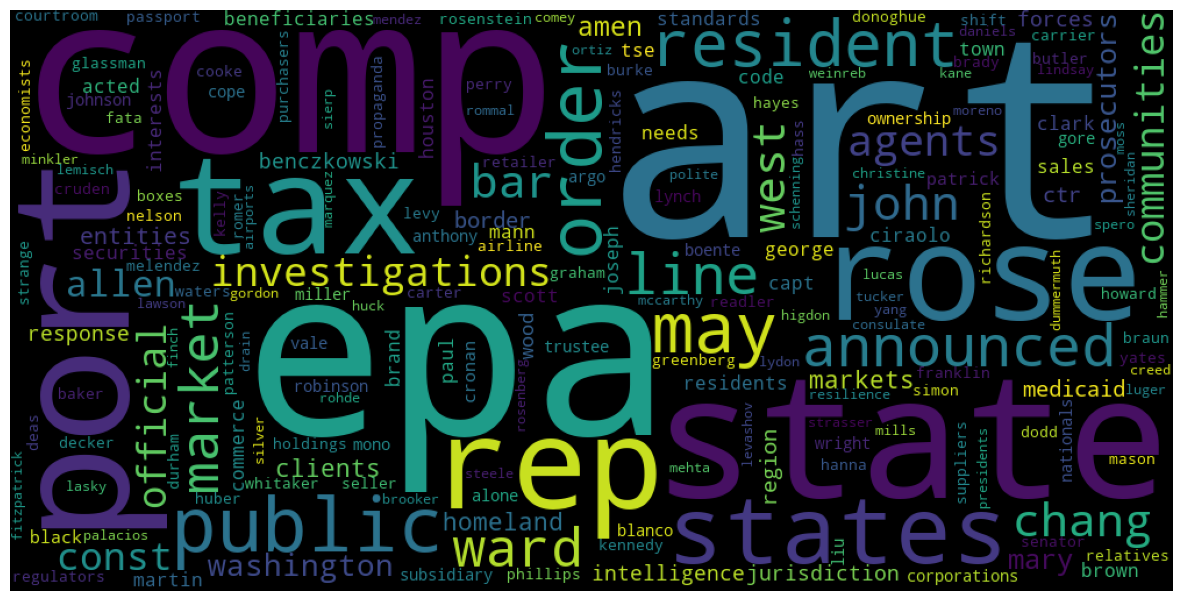

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(trump_counts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<Figure size 1500x800 with 0 Axes>

(-0.5, 999.5, 499.5, -0.5)

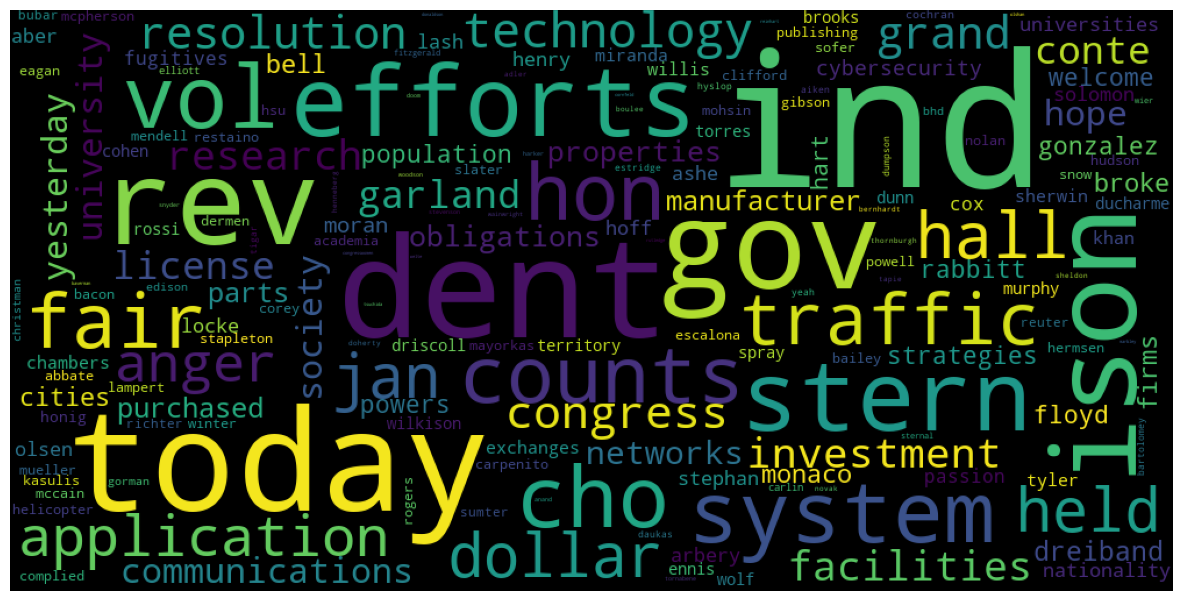

In [69]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(biden_counts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<Figure size 1500x800 with 0 Axes>

(-0.5, 999.5, 499.5, -0.5)

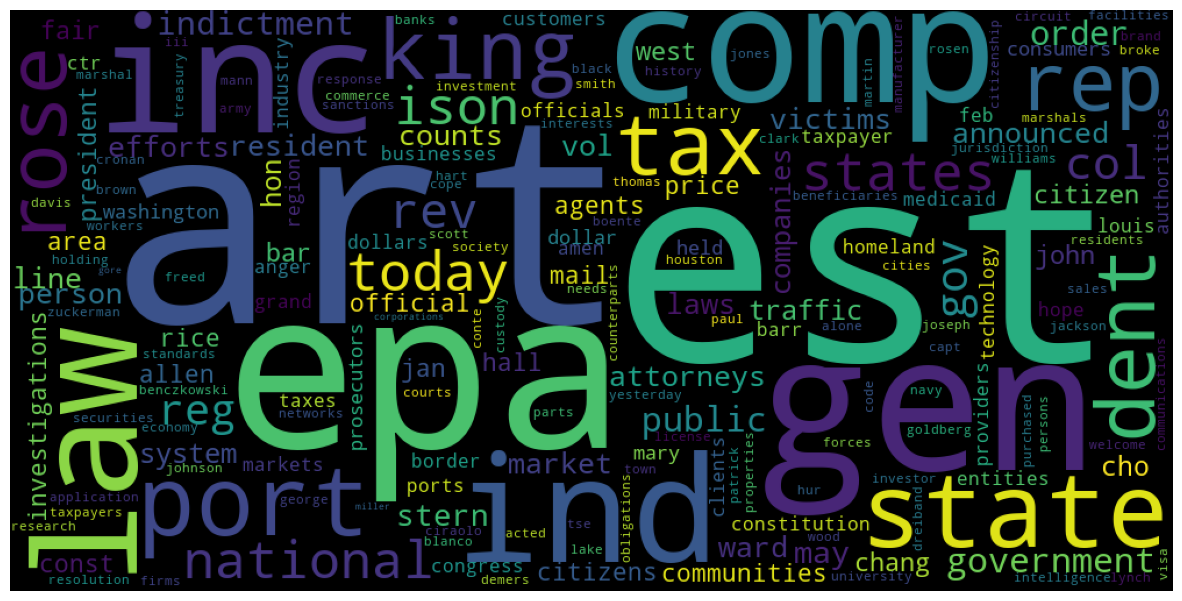

In [71]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(total_counts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()